# MNIST INRs Classification

A quick start notebook for performing INR classification with DWSNets.

**Make sure you change the runtime type to GPU before starting!**

In [1]:
# if not installed already, please install dwsnets and all its dependancies.
! git clone https://github.com/AvivNavon/DWSNets.git

Cloning into 'DWSNets'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 173 (delta 47), reused 45 (delta 45), pack-reused 118
Receiving objects: 100% (173/173), 1.21 MiB | 2.58 MiB/s, done.
Resolving deltas: 100% (98/98), done.


In [ ]:
cd DWSNets

In [ ]:
!pip install -e .

## Get Data
Next, we download the MNIST INR dataset and place it in `dataset/mnist-inrs`.

In [5]:
!mkdir dataset

In [6]:
!wget https://www.dropbox.com/sh/56pakaxe58z29mq/AABtWNkRYroLYe_cE3c90DXVa?dl=0 -O data_files.zip

--2023-04-23 09:27:02--  https://www.dropbox.com/sh/56pakaxe58z29mq/AABtWNkRYroLYe_cE3c90DXVa?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/56pakaxe58z29mq/AABtWNkRYroLYe_cE3c90DXVa [following]
--2023-04-23 09:27:03--  https://www.dropbox.com/sh/raw/56pakaxe58z29mq/AABtWNkRYroLYe_cE3c90DXVa
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc231f80f5a682e94d635680879f.dl.dropboxusercontent.com/zip_download_get/BeFNSUJ8MikFW7hvS69c3ul_jT5Nq5Y-FMCN85KBaaizMqCPMxpzYbaFhxYTSG_hpQ9ITUdRHsp79SGoLaNrMI6YeP1W-mRmInaG8GRZGuimBQ# [following]
--2023-04-23 09:27:04--  https://uc231f80f5a682e94d635680879f.dl.dropboxusercontent.com/zip_download_get/BeFNSUJ8MikFW7hvS69c3ul_jT5Nq5Y-FMCN85KBaaizMqCPMxpzYbaFhxYTSG_hpQ9ITUdRHsp79SGoLaNrMI6Ye

In [ ]:
!unzip -q data_files.zip

In [8]:
!unzip -q mnist-inrs.zip -d dataset

## Import Dependencies

In [11]:
import logging
from argparse import ArgumentParser

import torch
import torch.nn.functional as F
import wandb
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader
from tqdm import trange

from experiments.data import INRDataset
from experiments.utils import (
    common_parser,
    count_parameters,
    get_device,
    set_logger,
    set_seed,
    str2bool,
)
from nn.models import DWSModelForClassification, MLPModelForClassification

from experiments.mnist.generate_data_splits import generate_splits
from experiments.mnist.compute_statistics import compute_stats

set_logger()

Next, create the data split using:

```shell
python ../experiments/mnist/generate_data_splits.py --data-path dataset/mnist-inrs --save-path dataset
```
This will create a json file `dataset/mnist_splits.json`.


Next, compute the dataset (INRs) statistics using `compute_statistics.py`:
```shell
python ../experiments/mnist/compute_statistics.py --data-path dataset/mnist_splits.json
```
This will create `dataset/statistics.pth` object.

In [12]:
# create dataset splits (train/val/test)
generate_splits(data_path="dataset/mnist-inrs", save_path="dataset")

In [13]:
# compute dataset statistics - could take few minutes
compute_stats(data_path="dataset/mnist_splits.json", save_path="dataset", batch_size=1024)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## INR Dataset

We create INR Datasets and Dataloaders, and visualize some INRs (by reconstruction the images).



In [14]:
path = "dataset/mnist_splits.json"
statistics_path = "dataset/statistics.pth"
normalize = True
augmentation = True

batch_size = 512
num_workers = 4

### INR Reconstruction

First let's take a look at some INRs and INR augmentations

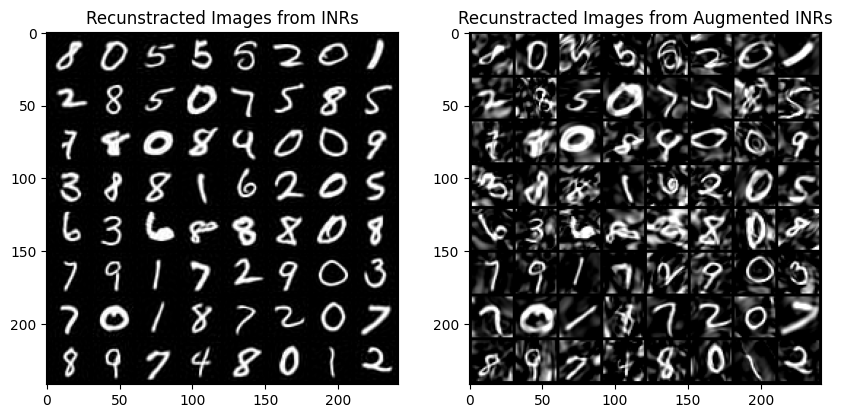

In [15]:
from torchvision.utils import save_image, make_grid
import torch

from experiments.data import INRImageDataset
from experiments.utils import set_seed
import matplotlib.pyplot as plt

dataset = INRImageDataset(
    path=path,  # path to splits json file
    augmentation=False,
    split="train",
)
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

dataset_aug = INRImageDataset(
    path=path,  # path to splits json file
    augmentation=True,
    split="train",
)
loader_aug = torch.utils.data.DataLoader(dataset_aug, batch_size=64, shuffle=False)

batch = next(iter(loader))
batch_aug = next(iter(loader_aug))

fig, axs = plt.subplots(1, 2, figsize=(10,20)) 

axs[0].imshow(make_grid(batch.image.squeeze(-1)).permute(1, 2, 0).clip(0, 1))
axs[0].set_title('Recunstracted Images from INRs')

axs[1].imshow(make_grid(batch_aug.image.squeeze(-1)).permute(1, 2, 0).clip(0, 1))
axs[1].set_title('Recunstracted Images from Augmented INRs')
plt.show()

---

## Create Dataloaders

In [16]:
train_set = INRDataset(
        path=path,
        split="train",
        normalize=normalize,
        augmentation=augmentation,
        statistics_path=statistics_path,
    )

val_set = INRDataset(
    path=path,
    split="val",
    normalize=normalize,
    statistics_path=statistics_path,
)

test_set = INRDataset(
    path=path,
    split="test",
    normalize=normalize,
    statistics_path=statistics_path,
)


train_loader = torch.utils.data.DataLoader(
        dataset=train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
)

logging.info(
    f"train size {len(train_set)}, "
    f"val size {len(val_set)}, "
    f"test size {len(test_set)}"
)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#### Let's look at the input INRs' shapes: Weight matrices are of shapes (in_dim, out_dim, channels), and biases are of shape (out_dim, channels).

In [17]:
point = train_set.__getitem__(0)
list(point.as_dict().keys())

['weights', 'biases', 'label']

In [18]:
# weights
[w.shape for w in point.weights]

[torch.Size([2, 32, 1]), torch.Size([32, 32, 1]), torch.Size([32, 1, 1])]

In [19]:
# biases
[b.shape for b in point.biases]

[torch.Size([32, 1]), torch.Size([32, 1]), torch.Size([1, 1])]

## Initialize DWSNet

In [20]:
# get device
device = get_device()
logging.info(f"device = {device}")

In [21]:
# shapes to initialize the DWSNet
weight_shapes = tuple(w.shape[:2] for w in point.weights)
bias_shapes = tuple(b.shape[:1] for b in point.biases)

logging.info(
    f"\nweight shapes: {weight_shapes}"
    f"\nbias shapes: {bias_shapes}"
)

model = DWSModelForClassification(
    weight_shapes=weight_shapes,
    bias_shapes=bias_shapes,
    input_features=1,
    hidden_dim=32,
    n_hidden=4,
    bn=True,
).to(device)

In [22]:
logging.info(f"number of parameters: {count_parameters(model)}")

## Eval Function

In [23]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    loss = 0.0
    correct = 0.0
    total = 0.0
    predicted, gt = [], []
    for batch in loader:
        batch = batch.to(device)
        inputs = (batch.weights, batch.biases)
        out = model(inputs)
        loss += F.cross_entropy(out, batch.label, reduction="sum")
        total += len(batch.label)
        pred = out.argmax(1)
        correct += pred.eq(batch.label).sum()
        predicted.extend(pred.cpu().numpy().tolist())
        gt.extend(batch.label.cpu().numpy().tolist())

    model.train()
    avg_loss = loss / total
    avg_acc = correct / total

    return dict(avg_loss=avg_loss, avg_acc=avg_acc, predicted=predicted, gt=gt)

## Model training

In [24]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3, amsgrad=True, weight_decay=5e-4)

In [25]:
epochs = 5  # doing just 5 epochs here, in the paper we do 100

In [ ]:
epoch_iter = trange(epochs)
criterion = nn.CrossEntropyLoss()
test_acc = -1

for epoch in epoch_iter:
    for i, batch in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()

        batch = batch.to(device)
        inputs = (batch.weights, batch.biases)
        out = model(inputs)

        loss = criterion(out, batch.label)
        loss.backward()
        optimizer.step()

        epoch_iter.set_description(
            f"[{epoch} {i+1}], train loss: {loss.item():.3f}, test acc: {test_acc:.3f}"
        )
        test_loss_dict = evaluate(model, test_loader)
        test_acc = test_loss_dict['avg_acc'].item()

---